### analysis ideas:
- show that it is integrating
- test against variable stimulus duration. longer implies both predict positive. 
- psychophysical kernel with pulse at the beginning, should be more likely to push one direction



### training ideas:
- daniel: increase spectral radius
- correlated recurrent noise?


### task ideas
- mask more time to give delay
- make task even harder


### backend todo:

# Import

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sisyphus2.backend import analysis, visualizations, simulation_tools
from sisyphus2.backend.networks import Model
from sisyphus2.tasks import task

In [2]:
rdm = task.rdm2(stim_noise = 0.02, coherences = [0.02], rec_noise = .01, N_rec = 5)

In [3]:
gen = rdm.generate_train_trials()

In [4]:
params = rdm.__dict__

In [108]:
rdm = task.rdm2(stim_noise = 0.1, coherences = np.linspace(.01, .2, 100), rec_noise = .01, N_rec = 5)

# Load Weights

In [5]:
weights_path = '../weights/rdm_5_rec.npz'

In [116]:
weights_path = '../weights/rdm_4_rec.npz'

In [51]:
weights_path = '../weights/rdm_10_rec.npz'

In [5]:
weights_path = '../weights/rdm_david.npz'

# Generate Trials

In [6]:
sim = simulation_tools.Simulator(params, weights_path=weights_path)
dat = gen.next()
trial = dat[0][0,:,:]
result = dat[1][0,:,:]

In [7]:
trial = np.vstack((trial, np.zeros((1000,2))))

In [7]:
output,states = sim.run_trial(trial)

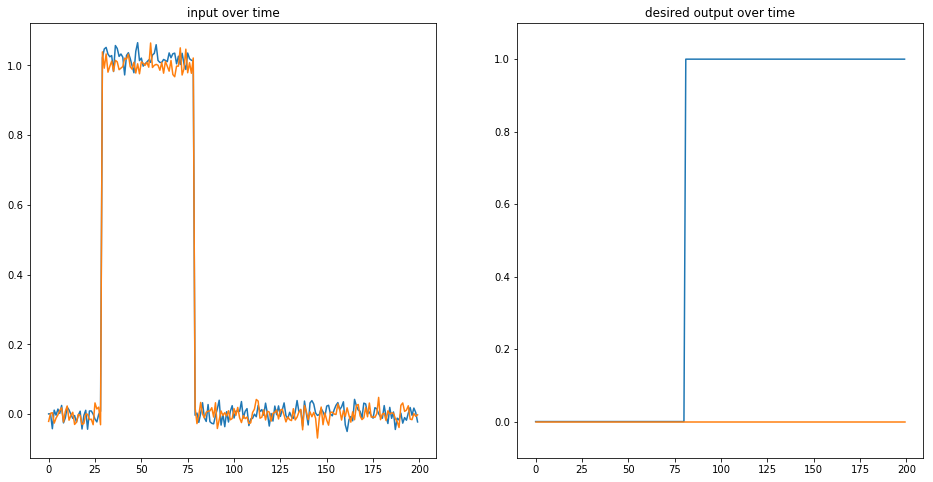

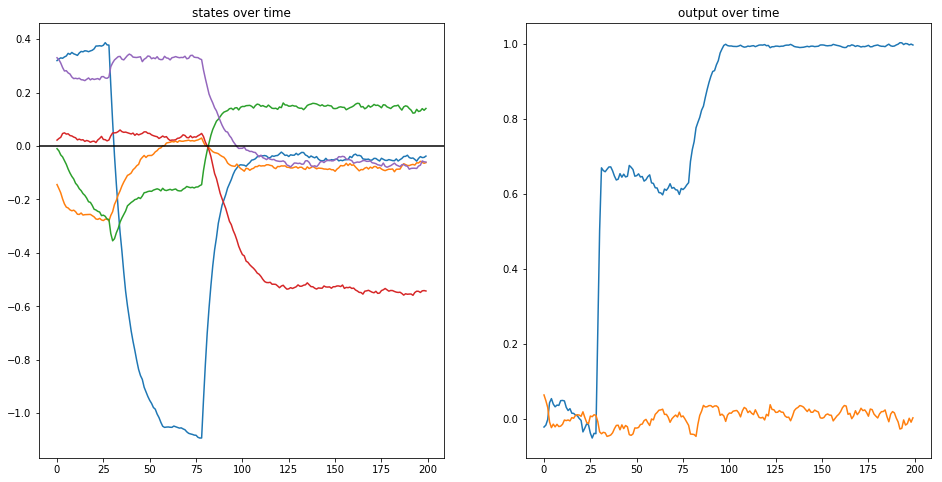

In [8]:

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(trial)
plt.title("input over time")

plt.subplot(1,2,2)
plt.plot(result)
plt.ylim(-0.1, 1.1)
plt.title("desired output over time")

plt.show()

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(states[:,0,:])
plt.axhline(y=0, color='k')
plt.title("states over time")

plt.subplot(1,2,2)
plt.plot(output[:,0,:])
plt.title("output over time")
plt.show()

In [307]:
blue_trial = trial

In [311]:
orange_trial = trial

# Distance to fixed point

In [38]:
def distance_to_fixed(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    dists = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find fixed point at this time step
        # (even if it is outside the current partition)
        fixed_point = -1 * np.matmul(np.linalg.inv(Wp), sim.b_rec + input_mat[:,i])
        
        #calculate distance to fixed point
        d = np.linalg.norm(fixed_point - s)
        dists.append(d)
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(dists)
    ax1.set_title('Distance to Fixed Point')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

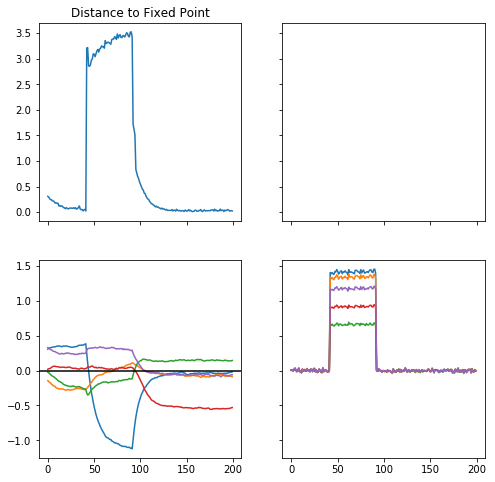

In [39]:
distance_to_fixed(sim, trial)

# Distance to Final Fixed Point

In [94]:
# for rdm_10_rec
fp1 = [ 0.70322314, -0.21220454,  0.42586755,  0.45786433,  0.86620442,
        -0.07819017, -0.18917653, -0.14375263,  0.57091555, -0.9131199 ]
fp2 = [-0.21374657,  0.4618243 , -0.46038991,  0.43066988, -0.42712579,
        -0.43483795,  0.30266692,  0.58161119, -0.16717428, -0.01333921]
fp3 = [-0.13135733, -0.09012359,  0.04480331, -0.11539256, -0.04676911,
         0.37516717, -0.04543317, -0.0355923 , -0.07917503,  0.08330037]

In [10]:
# for rdm_5_rec
fp1 = [ 0.36320676,  0.61929652,  1.30060302,  1.25145486, -3.07111575]
fp2 = [-0.88723986,  0.94818675, -0.29864507,  0.32246673, -0.94195069]
fp3 = [-0.0601163 , -0.1548662 , -0.04169023, -0.18174691,  0.61411446]

In [11]:
def fp_dists(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    dists1 = []
    dists2 = []
    dists3 = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find fixed point at this time step
        # (even if it is outside the current partition)
        fixed_point = -1 * np.matmul(np.linalg.inv(Wp), sim.b_rec + input_mat[:,i])
        
        #calculate distance to fixed point
        d = np.linalg.norm(fp1 - s)
        dists1.append(d)
        
        d = np.linalg.norm(fp2 - s)
        dists2.append(d)
        
        d = np.linalg.norm(fp3 - s)
        dists3.append(d)
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(dists1)
    ax1.set_title('Distance to Fixed Point 1')
    ax2.plot(dists2)
    ax2.set_title('Distance to Fixed Point 2')
    ax4.plot(dists3)
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

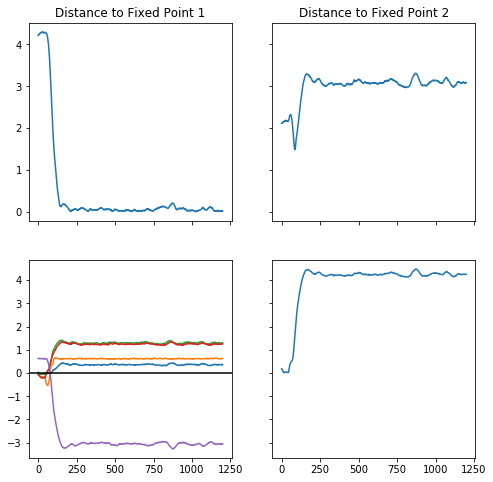

In [12]:
fp_dists(sim, trial)

# Plot eigenvalues

In [40]:
def plot_eigvals(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    vals = []
    proj = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find eigenvals (real part) at this time step
        l, v = np.linalg.eig(Wp)
        vals.append(np.real(l))
        
        # project 
        proj_s = np.matmul(v, np.transpose(s))
        proj.append(np.transpose(proj_s))
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,12))
    ax1.plot(vals[:])
    ax1.set_title('Eigenvalues')
    #ax1.axhline(y=0, color='k')
    ax2.axhline(y=0, color='k')
    ax2.plot(np.array(proj)[:,0,:])
    ax2.set_title('Eigenbasis projection')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

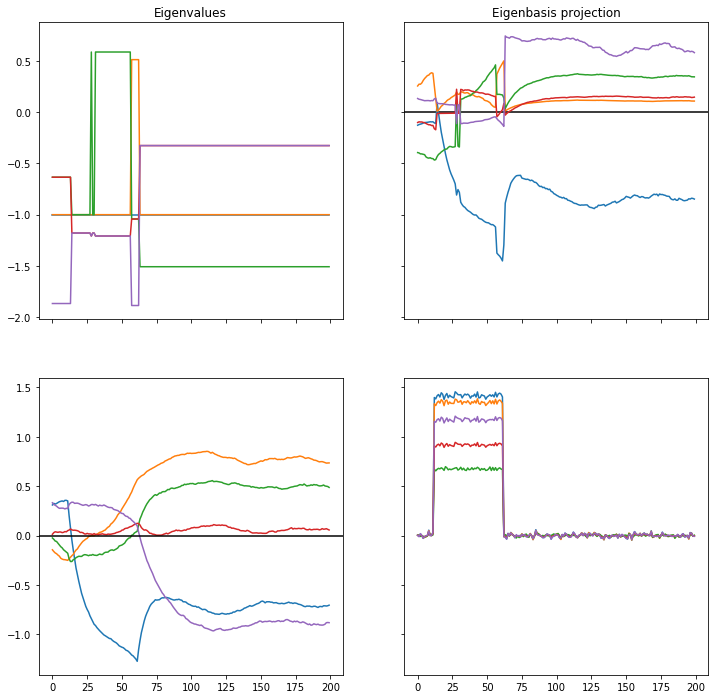

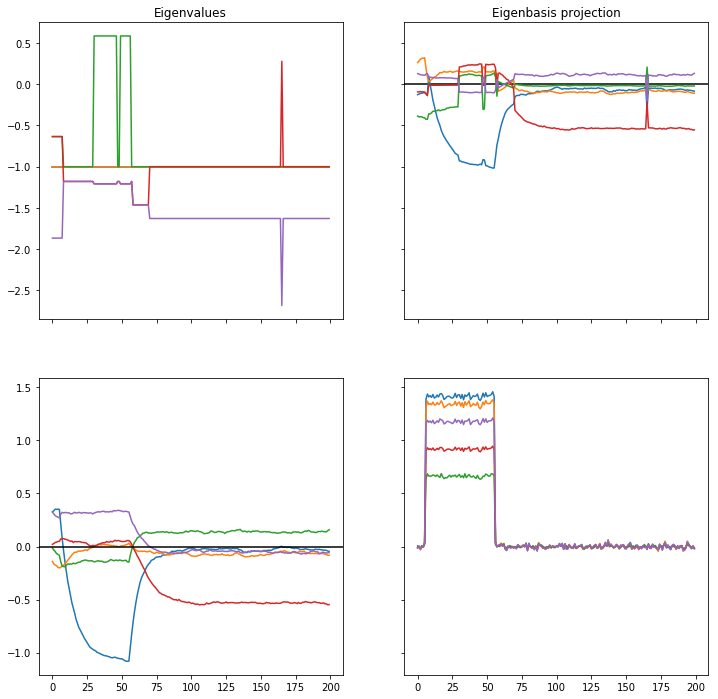

In [321]:
plot_eigvals(sim, orange_trial)
plot_eigvals(sim, blue_trial)

In [343]:
from sets import Set
def plot_integrating_eigvals(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    vals = []
    vecs = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find eigenvals (real part) at this time step
        l, v = np.linalg.eig(Wp)
        vals.append(np.real(l))
        vecs.append(v)
         
    # find integrating modes
    integrating_vecs = []
    for i in range(len(states)):
        for j in range(5):
            if np.transpose(input_mat)[i,0] > .1:
                if -.75 < vals[i][j] and vals[i][j] < .75:
                    integrating_vecs.append(vecs[i][j])
    
    iv = []
    for v in integrating_vecs:
        flag = True
        for vv in iv:
            if np.equal(v, vv).all():
                flag = False
        if flag:
            iv.append(v)
    
    # project 
    plt.plot(np.transpose(input_mat))
    plt.axhline(y=0, color='k')
    plt.show()
    
    cumsum = np.zeros(trial.shape[0])
    for i in range(1,len(states)):
        cumsum[i] = cumsum[i-1] - (trial[i,0] - trial[i,1])
    plt.plot(cumsum, color = 'k')
    plt.axhline(y=0, color='k')
    
    for v in vecs_orange:
        proj = []
        for i, s in enumerate(states):
            proj_s = np.matmul(v, np.transpose(s))
            proj.append(np.transpose(proj_s))
            
        #plt.plot(np.array(proj)[:,:], color = 'orange')
    for v in [vecs_blue[2]]:
        proj = []
        for i, s in enumerate(states):
            proj_s = np.matmul(v, np.transpose(s))
            proj.append(np.transpose(proj_s))
            
        plt.plot(np.array(proj)[:,:])
        
    plt.show()
    return iv

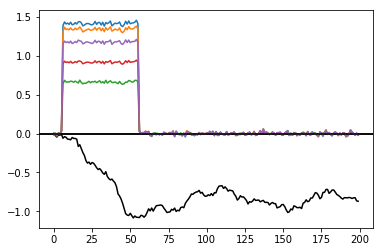

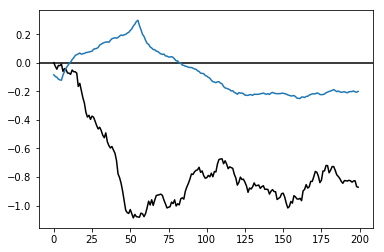

In [344]:
vecs = plot_integrating_eigvals(sim, blue_trial)

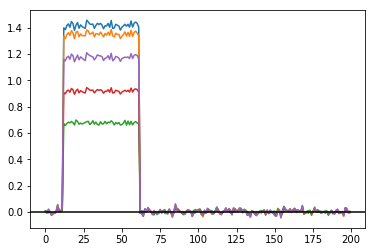

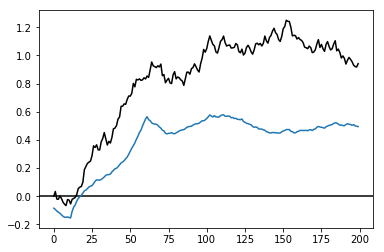

In [345]:
vecs = plot_integrating_eigvals(sim, orange_trial)

In [223]:
vecs_orange = vecs

In [246]:
vecs_blue = vecs

In [258]:
vecs_blue

[array([ 0.00000000+0.j        ,  1.00000000+0.j        ,
        -0.02599373-0.49613212j, -0.02599373+0.49613212j, -0.75577021+0.j        ]),
 array([ 0.00000000+0.j       ,  0.00000000+0.j       ,
         0.39018414+0.3202302j,  0.39018414-0.3202302j, -0.29328231+0.j       ]),
 array([ 0.00000000+0.j        ,  1.00000000+0.j        ,
        -0.34755881+0.j        ,  0.14132434-0.46803275j,
         0.14132434+0.46803275j])]

In [259]:
vecs_orange

[array([ 0.00000000+0.j        ,  1.00000000+0.j        ,
        -0.02599373-0.49613212j, -0.02599373+0.49613212j, -0.75577021+0.j        ]),
 array([ 0.00000000+0.j       ,  0.00000000+0.j       ,
         0.39018414+0.3202302j,  0.39018414-0.3202302j, -0.29328231+0.j       ]),
 array([ 0.        ,  0.        ,  1.        ,  0.22036646, -0.8293378 ]),
 array([ 0.00000000+0.j        ,  1.00000000+0.j        ,
        -0.34755881+0.j        ,  0.14132434-0.46803275j,
         0.14132434+0.46803275j]),
 array([ 0.00000000+0.j        ,  0.74726234+0.j        ,
         0.26621119-0.06327821j,  0.26621119+0.06327821j,  0.08767897+0.j        ])]

In [201]:
np.matmul(vecs_up[1], np.transpose(vecs_down[1]))

(0.18540706351477138+0j)

# Print Partition numbers

In [364]:

def print_partitions(sim, trial):
    outputs, states = sim.run_trial(trial)
    
    parts = []
    for i,s in enumerate(states):
        if trial[i,0] > 0.1:
            p = 0
            for i in range(len(s[0])):
                p += int(s[0][i] > 0) * pow(2,i)
            parts.append(p)
    
    print parts

In [365]:
print_partitions(sim, orange_trial)

[25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 26, 26, 26, 26, 18, 18, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 30, 30]


In [366]:
print_partitions(sim, blue_trial)

[25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


In [320]:
sim.W_rec

array([[ 0.22239429, -0.28151521, -1.17539322, -0.54549384,  0.65863818],
       [-0.44827539,  1.52795458, -0.80567634, -0.69912851, -0.54973185],
       [-1.71212804,  0.71932745, -0.62856728,  0.57250291,  0.39908358],
       [ 0.63169998,  0.85550284, -0.19054735, -0.05974017,  1.20992827],
       [ 0.79139382, -0.68344182, -0.79522181, -0.27571318, -0.29837701]], dtype=float32)

In [380]:
p = 26
print bin(p)
bin_p = [int(x) for x in bin(p)[2:]]
mask = np.zeros(sim.W_rec.shape)

for i in range(sim.W_rec.shape[0]):
    if bin_p[i]:
        for j in range(sim.W_rec.shape[0]):
            mask[j,sim.W_rec.shape[0] - 1 - i] = 1

Wp = mask * sim.W_rec

0b11010


In [381]:
Wp

array([[ 0.        , -0.28151521, -0.        , -0.54549384,  0.65863818],
       [-0.        ,  1.52795458, -0.        , -0.69912851, -0.54973185],
       [-0.        ,  0.71932745, -0.        ,  0.57250291,  0.39908358],
       [ 0.        ,  0.85550284, -0.        , -0.05974017,  1.20992827],
       [ 0.        , -0.68344182, -0.        , -0.27571318, -0.29837701]])

In [382]:
np.linalg.eig(Wp - np.diag(np.ones(sim.N_rec)))

(array([-1.00000000+0.j        , -1.00000000+0.j        ,
         0.58591617+0.j        , -1.20803938+0.80200613j,
        -1.20803938-0.80200613j]),
 array([[ 1.00000000+0.j        ,  0.00000000+0.j        ,
          0.33502094+0.j        ,  0.29882443+0.47058539j,
          0.29882443-0.47058539j],
        [ 0.00000000+0.j        ,  0.00000000+0.j        ,
         -0.79641568+0.j        ,  0.11497983+0.14025949j,
          0.11497983-0.14025949j],
        [ 0.00000000+0.j        ,  1.00000000+0.j        ,
         -0.34755881+0.j        ,  0.14132434-0.46803275j,
          0.14132434+0.46803275j],
        [ 0.00000000+0.j        ,  0.00000000+0.j        ,
         -0.18205545+0.j        ,  0.56475901+0.j        ,  0.56475901-0.j        ],
        [ 0.00000000+0.j        ,  0.00000000+0.j        ,
          0.31550232+0.j        , -0.15052040+0.27517978j,
         -0.15052040-0.27517978j]]))

# Daniel's old tests (only noise input, etc)

In [9]:
def plot_response_test(sim, x_gen, n_iters):
    

    mean_up = 0
    mean_down = 0
    total_choice = np.zeros(128 * n_iters)
    total_resp = np.zeros(128 * n_iters)
    
    for jj in range(n_iters):
        x_test = x_gen.next()[0]
        choice = np.zeros(128)
        resp = np.zeros(128)
        for ii in range(128):
            o,s = sim.run_trial(x_test[ii,:,:])
            resp[ii] = o[-1,0,0]
            choice[ii] = np.sign(resp[ii] - .5)
        
        mean_up += np.mean(x_test[choice==1,:,:],axis=0)
        mean_down += np.mean(x_test[choice==-1,:,:],axis=0)
        total_choice[jj*128: (jj+1)*128] = choice
        total_resp[jj*128: (jj+1)*128] = resp
    
    mean_up = mean_up / n_iters
    mean_down = mean_down / n_iters
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(mean_up)
    plt.title('Average Up')
    plt.subplot(1,2,2)
    plt.plot(mean_down)
    plt.title('Average Down')
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.bar([0,1],[np.mean(total_choice==1),np.mean(total_choice==-1)])
    plt.xticks([.35,1.45],['Up','Down'])
    plt.xlabel('Percent Up')
    plt.subplot(1,2,2)
    plt.hist(total_resp,20)
    plt.title('Response Histogram')
    plt.show()
    
    return mean_up,mean_down,choice,resp

def coherence_test(sim,cohs = [.2,.1,.05,.04,.02],n_hidden=10,sigma_in = 0):
    
    n_cohs = len(cohs)
    a = np.zeros([200,1])
    a[40:140] = 1
    o = np.zeros([200,n_cohs])
    s = np.zeros([200,n_hidden,n_cohs])
    ev = np.zeros([200,n_cohs])
    for ii,coh in enumerate(cohs): 
        inp = coh*a + sigma_in*np.random.randn(len(a),1)
        o_temp,s_temp = sim.run_trial(inp,t_connectivity=False)
        o[:,ii] = o_temp[:,0,:].flatten()
        s[:,:,ii] = s_temp[:,0,:]
        ev[:,ii] = np.cumsum(coh*a)

    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(o)
    plt.title('output')
    
    plt.subplot(1,2,2)
    plt.plot(ev)
    plt.title('sum of evidence')
    
    plt.show()
    
    return o,s

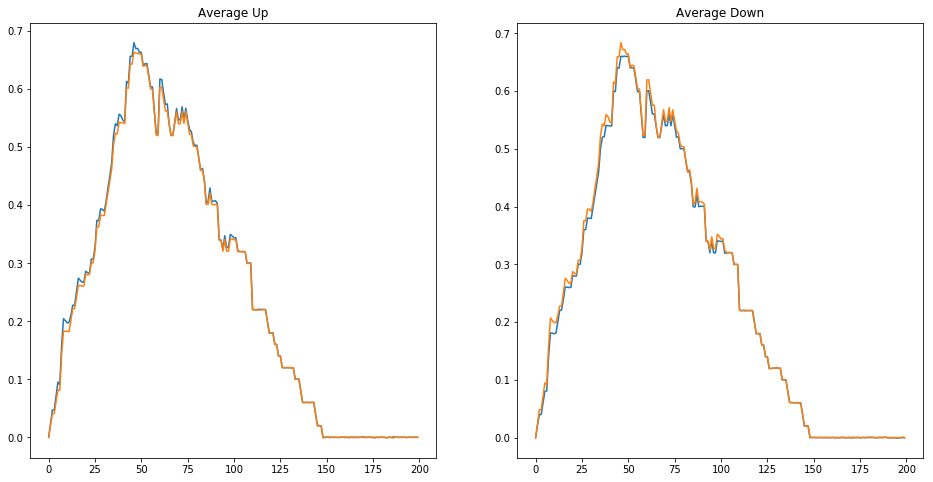

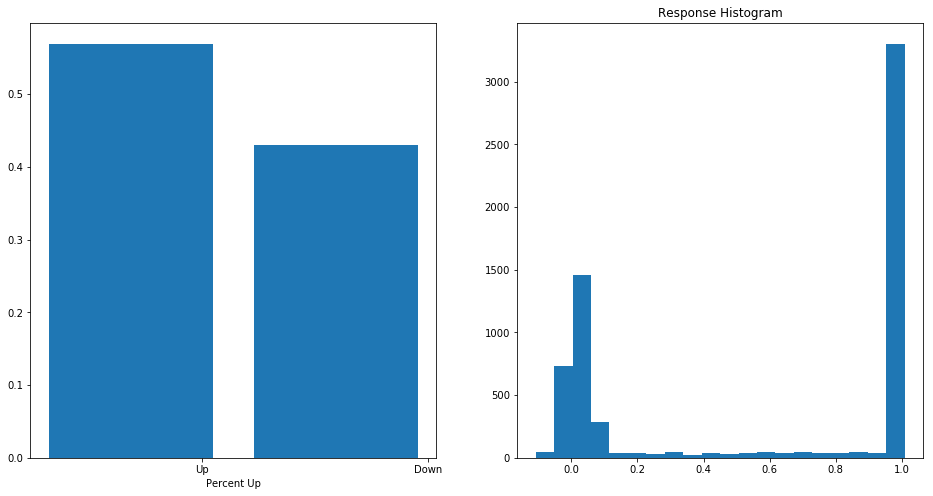

In [12]:
rdm2 = task.rdm2blip(stim_noise = 0.02, coherences = [0], rec_noise = .01, N_rec = 5)
gen2 = rdm2.generate_train_trials()


a = plot_response_test(sim, gen2, 50)
#b = coherence_test(sim, cohs = np.linspace(-.2, .2, 20), n_hidden = 10)